Ethan Yoder

In [1]:
# Import packages

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Useful plotting functions to use later

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def hits_on_diagonal(hits):
    """Picks out which hits lie roughly along the diagonal"""

    slope1 = 1.0e6 / (825000 - 48000)
    slope2 = 1.0e6 / (914000 - 141000)
    offset1 = 0 - slope1*48000
    offset2 = 0 - slope2*141000

    goodhits = []

    for hit in hits:
        upper = slope1 * hit[0] + offset1
        lower = slope2 * hit[0] + offset2

        if lower < hit[1] < upper:
            goodhits.append(hit)

    return goodhits

def plot_hits(hits):
  ## This helps to draw the diagonal line and
  ## highlight the region around it.
  ## Feel free to change the aesthetics of the plot!
    if len(hits)==0:
        print('No hits found!')
        return
        sns.set('paper')
        sns.set_style('whitegrid')

    plt.figure()

    slope1 = 1.0e6 / (825000 - 48000)
    slope2 = 1.0e6 / (914000 - 141000)
    offset1 = 0 - slope1*48000
    offset2 = 0 - slope2*141000

    x = np.linspace(0,1e6,int(1e5))
    plt.plot(x, slope1*x+offset1, 'b-')
    plt.plot(x, slope2*x+offset2, 'b-')
    plt.xlim(0, 1e6)
    plt.ylim(0, 1e6)

    hits = np.array(hits)
    x = hits[:,0]
    y = hits[:,1]
    pos = np.arange(hits.max())
    plt.scatter(x,y, s=1,c='grey',marker='x')

  # plt.ylabel('Sequence 1')
  # plt.xlabel('Sequence 2')

    hits2 = hits_on_diagonal(hits)
    plt.title(f"{len(hits)} hits, {100*len(hits2)/len(hits):0.2f} on diagonal)")

    plt.show()
    return None


# Sequence Alignment

Sequence alignment is a fundamental concept in bioinformatics and molecular biology. It involves the comparison of genetic sequences to identify similarities, differences, and evolutionary relationships between DNA, RNA, or protein sequences.

In the context of read mapping, which is crucial in fields like genomics and molecular biology, sequence alignment is used to align short DNA sequences (reads) obtained from high-throughput sequencing techniques (like next-generation sequencing) to a reference genome or another sequence. This process helps identify where these short reads belong in the context of the larger reference sequence, allowing researchers to understand the structure, function, and variations in the genetic material.

One interesting application of sequence alignment is the comparison of two reference sequences to perform **comparative genomics**. Alignment allows the comparison of genomes across species to study evolutionary relationships and genetic similarities.


In Lecture 6, we started looking at the algorithmic problem of sequence alignment in the context of read mapping.


 We began to realise that figuring out the best way to align two sequences is a challenging problem, and requires some more advanced algorithmic approaches.

![image.png](https://miro.medium.com/max/1400/1*MvF9NUzn54va1_TO8RMLoA.png)

[Image reference](https://miro.medium.com/max/1400/1*MvF9NUzn54va1_TO8RMLoA.png)

If you are interested, the Needleman–Wunsch algorithm is used in bioinformatics to align protein or nucleotide sequences using dynamic programming. You can check out the [Wikipedia page](https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm) for an overview of how it works!

Still, sequence alignment is a quadratic time algorithm - meaning that it takes on the order of $n^2$ operations to align a sequence of length $n$. Full sequence alignment is therefore only possible for sequence about the length of the average gene - certainly not for comparing two genomes!

## K-mer Hashing

In this project, we will explore the use of **k-mer hashing** as a heuristic for aligning large regions. K-mers are substrings of length k within DNA sequences. The process involves breaking longer sequences into shorter k-mers and creating a hash table to efficiently store and compare these k-mers.


Hashing is the process of transforming any given key or a string of characters into another shorter, fixed-length value or key which is easier to find. Keys in a dictionary are hashed to make looking up items in a dictionary very quick!


By comparing the presence, absence, or frequency of k-mers across genomes, we can determine shared genetic material or specific variations between organisms.

## Evolutionary Conservation of HoxA Cluster

In this project, you will use hashing techniques to
guide the alignment of a 1 megabase (1 million nucleotides) region surrounding the HoxA cluster in human
(provided as a FASTA file human-hoxa-region.fa) and mouse (provided as a FASTA file mouse-hoxa-region.fa). The Hox genes are a highly conserved group of genes that play a crucial role in the embryonic development of many animals, including humans and mice. These genes are involved in controlling the body plan and are responsible for the anterior-posterior (head-to-tail) patterning of an organism during early development. They play a role in determining where specific body structures will develop and the timing of their development.


This assignment is adapted from a Problem Set from MIT's 6.047 ([Computational Biology](https://ocw.mit.edu/courses/6-047-computational-biology-fall-2015/)) course.


1. (5 points) First thing first, we want to write a function to read in a FASTA file, and return the sequence contained therein. Remember to ignore any lines that correspond to comments, and remove any special characters from the sequence!

Load the file `'mouse-hoxa-region.fa'` and save it as the variable `seq1`. Load the file `human-hoxa-region.fa` and save it as the variable `seq2`.


In [24]:
def read_fasta(filename):
    
    """
  Reads in the path to a FASTA file, and returns the sequence contained therein.
  Comment lines are removed.

  @param: (str) filename - path to FASTA file
  @return: (str) sequence contained in fasta file
    """
    
    sequence = ""
    
    with open (filename, 'r') as f:
        
        for line in f:
            
            if line.startswith('>') or line.startswith(';'):
                continue
            
            sequence += line.rstrip('\n')

    return sequence

In [25]:
path_to_data = r'/Users/ethanyoder/Downloads/'

seq2 = read_fasta(path_to_data+'human-hoxa-region.fa')
seq1 = read_fasta(path_to_data+'mouse-hoxa-region.fa')

In [26]:
# Print first 1000 characters
seq1[:100]

'AAGTAAAGATCATGGTTCTAAAAACTGAAATTTACCACTGAAATTCATATGGGTTCTATTGGACTTTAATCCTGTGTTTGTCAGGCAGCACTGAAAACCC'

In [27]:
# Print first 1000 characters
seq2[:1000]

'CTAACACCAAACAGAGAACTAGTTTTCACCAATTAAAGAGCAGTTTGATTATACGCCATGTAAAATGCTAATGCAGAAATGAACAATAGCTATTTCTCATTTAAATTTAGTCATCTGGAATGCTTCAAGTAGATAACATTAATGCAAGATGATACAATGCATCCAGATATTGGCAGTAGATTGATTTAAGTAGACATAAATGATCTTTAAAAAATCAGCAACCTTCAGAAGCTGCTTACATCACTTTTGCTTTATTTATGTAATGTAGTCACACATTAATTAGCAATACTGTACAAGAATAGAAAATCATAATTTAGGCCAGGCATGGTGGCTTACGCCTGAAATCCCAGCACTTTGGGAGGCCAAGGCAGGCAGATCACTTGAGGTGAGGAGTTTGAGACCAGCCTGGCCAATATGGCGAAACCCCATCTCTACTAAAAATACAAAAAAATTAGCTGGGTGTGGTGGCACGTGCCTGTAGTCCCAGCTTCTAGGGAGGCTGAGGCATGAGAATCGCTTGAACCGGGGAAACAGAGGTTGCAGTGAGCAAAGATTGTGCCAGTGCACTCCAGCTAGGCAACAGAGGGAGACTGTCTCAAAAAAGAAGAAAGGAAAGAAAGAAAGGAAAGAAAGAAAGAGAAAGAAAGAAAATCATAATTTAACATATCTTTATCTTAGCCATCTATTCCTTGACCCACAAGGTCAAGCTTATGTCAGGACTAAATATCAATATAAACATTCAATTGCCCTCCTTTTTAAAAAGAACTCAACTGTTATTGTTGCAAGCTTAATTAAATACAAATTATTTAATTTGATTTAATAAACAGAAAATTATTCCAAAGAAGTGTACTTGGTATTTAGGGATGTGTTTTTTAAAAATTTAGAGCAAGACACAATTGAAAAGTTTGCAAGTAATGTCGATAATGGTGAAAAATCAGATACAACCTGATTTTTGTAAATAAAAATTAAGGTTTGCTTAAATATTTTTTTCACTTGGTA

We now wish to heuristically align our two sequences. We do this by storing all k-mers in the first string and performing a pairwise comparison with k-mers in the second string. The location of all k-mers that match are stored as a hit.

Clustered locations of 'hits' correspond to regions where there two sequences are quite similar. We store hits


2. (5 points). Write a function `collect_hits(seq1, seq2, kmerlen)` that iterates over both sequences and stores the indices of k-mers which are 'hits', as a list of tuples. Each tuple contains `(index1, index2)` where `index1` is the location of the k-mer in `seq1` and `index2` is the location of the k-mer in `seq2`.

For example, considering k-mers of length three, if we were to compare the following sequences:

ATTCGATGCT and GATGCTATATTCTAT, we would observe hits at `[(0,8), (1,9), (4,0), (5,1), (6,2), (7,3)]`, (corresponding to 3-mers 'ATT', 'TTC', 'GAT','ATG', 'TGC' and 'GCT'. This leads us to two regions where the sequences share similarity -
* **ATTC**GATGCT/GATGCTAT**ATTC**TAT
*  ATTC**GATGCT**/**GATGCT**ATATTCTAT


In [45]:
def collect_hits(seq1, seq2, kmerlen=30):
    """
  Find all positions on (seq1, seq2) where there is a matching k-mer.

  For example, if we consider an exact match rule with a k- mer length f 4:
   seq1[10] = 'AATC' and seq2[50] = 'AATC'
  would register a hit at position (10,50).

  @param: (str) seq1 representing sequence 1 to be aligned
  @param: (str) seq2 representing sequence 2 to be aligned
  @param: (int) kmerlen representing the length of k-mers to be hashed

  @ return: (list of tuples) where each entry on the list is a tuple of integers
            ([p1, p2]), at 'matching' where positions p1 represents the position
            on seq1 and p2 represents the position on seq2
  """
  # List of hit positions
    hits = []

  # Dictionary to store hashes of positions where k-mers are located
    lookup = {}

    print('Hashing sequence 1...')
    
    for pos1 in range(len(seq1) - kmerlen + 1):

    # Find the kmer in seq1 to hash
    # YOUR CODE HERE
        
        kmer = seq1[pos1:pos1 + kmerlen]
    # Store position of kmer under the hash of kmer (as a key in a dictionary)
        lookup.setdefault(kmer, []).append(pos1)

    print('Hashing sequence 2...')
    
    for pos2 in range(len(seq2) - kmerlen + 1):
     
    # Find the correct k-mer in sequence 2
    # YOUR CODE HERE
        kmer = seq2[pos2:pos2 + kmerlen]
        if kmer in lookup:
            for pos1 in lookup[kmer]:
                hits.append((pos1, pos2))
                
    # Lookup kmer locations in the lookup table
    # Store the positions of hits (where both seq1 and seq2 contain the same k-mer)


    return hits




In [46]:
collect_hits(seq1, seq2)

Hashing sequence 1...
Hashing sequence 2...


[(93072, 6345),
 (93073, 6346),
 (93074, 6347),
 (305239, 8480),
 (305240, 8481),
 (312355, 8481),
 (20797, 8482),
 (20801, 8482),
 (20805, 8482),
 (20809, 8482),
 (20813, 8482),
 (20817, 8482),
 (20821, 8482),
 (20825, 8482),
 (107602, 8482),
 (107606, 8482),
 (107610, 8482),
 (107614, 8482),
 (107618, 8482),
 (107622, 8482),
 (219357, 8482),
 (219361, 8482),
 (219365, 8482),
 (219369, 8482),
 (219373, 8482),
 (219377, 8482),
 (219381, 8482),
 (219385, 8482),
 (219389, 8482),
 (227721, 8482),
 (227725, 8482),
 (227729, 8482),
 (305241, 8482),
 (305245, 8482),
 (305249, 8482),
 (305253, 8482),
 (312356, 8482),
 (312360, 8482),
 (312364, 8482),
 (312368, 8482),
 (312372, 8482),
 (312376, 8482),
 (312380, 8482),
 (312384, 8482),
 (694064, 8482),
 (694068, 8482),
 (694072, 8482),
 (694076, 8482),
 (694080, 8482),
 (694084, 8482),
 (694088, 8482),
 (712929, 8482),
 (712933, 8482),
 (712937, 8482),
 (712941, 8482),
 (712945, 8482),
 (712949, 8482),
 (20798, 8483),
 (20802, 8483),
 (20806, 8

3. (3 points) Plot the hits you find using the provided `plot_hits()` function. Describe what you see. How many hits are there? What proportion of hits fall along the diagonal (within the two blue lines)? Why are matches that are close to the diagonal more likely than off-diagonal matches to represent “correct” alignments?


Hashing sequence 1...
Hashing sequence 2...


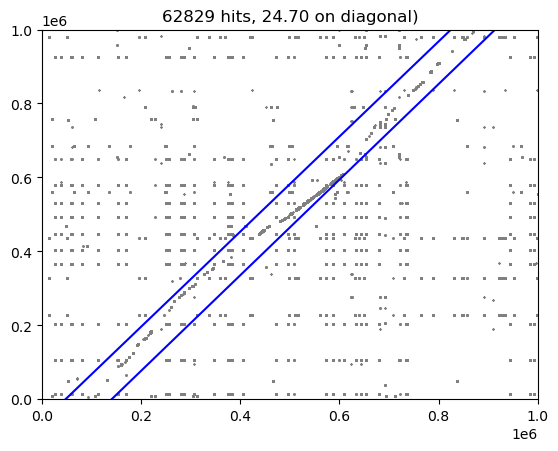

In [47]:
hits = collect_hits(seq1, seq2)
plot_hits(hits)

*Answer:* Therea are 62,829 hits, 24.7% of which fall within the diagnol. The matches close to the diagnol are more likely to represent "correct" alignments because this means that the matches are occuring around the same part of each sequence.

4. (2 points) Off diagonal matches: What causes such off-diagonal matches? Do you observe any structure in the off-diagonal hits? What types of genomic elements could cause such
a pattern?

*Answer:* off-diagnol matches could be just due to coincidence, given that 30 nucleotides is not a particularly large amount relatively speaking. Some sequences might also be repeated many times throughout both sequences if they code for a particular cluster of amino acids, so they might have multiple hits with the other sequence for the same set of nucleotides. While there are spots that have relatively few off-diagnol hits, there doesn't seem to be a particular structure or correlation outside of the diagnol, there's a lot of them pretty much all around the graph. This again might just be because 30 nucleotides is relatively small given how large the sequences are. Genes may have repeating sequences to code for the same set of proteins. Transposable elements can also move around the genome, creating more repeats.

## Modifying match criteria.

So far, we used an exact match with a k-mer length of 30 (30-mers). We can modify our algorithm to check for different types of match critera. In this problem, you will use tools you learned about strings to modify the match criteria.

2a. (1pt) Use the code you wrote above to find all exact matching 100-mers. After you run the code to generate the new hits with this match criteria, describe in words how you implemented this change. How does the plot changes qualitatively and quantatively (how many hits, what percentage are near the diagonal)?

Hashing sequence 1...
Hashing sequence 2...


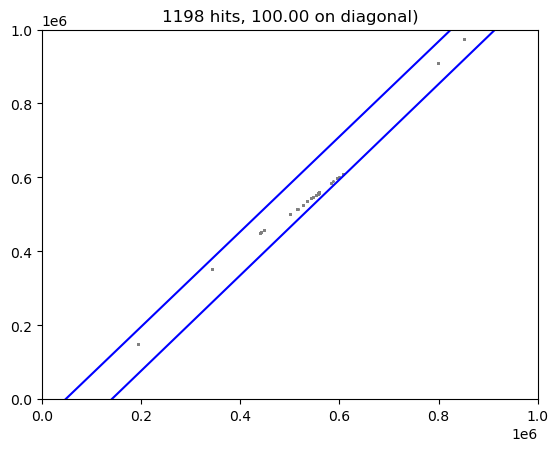

In [49]:
hits2 = collect_hits(seq1, seq2, kmerlen=100)
plot_hits(hits2)

*Answer:* To findmatching 100-mers, I just had to change the kmerlen parameter to 100 (the default is 30). The hits reduce to only 1198, 100% of which fall within the diagnol.

2b. (2pts) Write a function below that allows us to find all kmers of a given length, which match every `match_interval` bases. We will use to to compare hits for:
* 60-mers that match every *other* base `(match_interval=2)`
* 90-mers that match every *third* base `(match_interval=3)`
* 120-mers that match every *fourth* base `(match_interval=4)`

As a quick example:

**A**T**A**G**G** and **A**T**G**C**G** doesn't match at interval 2

**A**TA**G**G and **A**TG**C**G doesn't match at interval 3

**A**TAG**G** and **A**TGC**G** does match at interval 4

You should be able to use a lot of the code you wrote in `collect_hits()` in the previous question!

In [54]:
def collect_alternating_hits(seq1, seq2, kmerlen=30, match_interval=1):
    
    """
  Find all positions on (seq1, seq2) where there is a matching k-mer.

  For example, if we consider an exact match rule with a k- mer length f 4:
   seq1[10] = 'AATC' and seq2[50] = 'AATC'
  would register a hit at position (10,50).

  @param: (str) seq1 representing sequence 1 to be aligned
  @param: (str) seq2 representing sequence 2 to be aligned
  @param: (int) kmerlen representing the length of k-mers to be hashed (default 30)
  @param: (int) n representing the number how frequently to subselect bases from

  @ return: (list of tuples) where each entry on the list is a tuple of integers
            ([p1, p2]), at 'matching' where positions p1 represents the position
            on seq1 and p2 represents the position on seq2
  """

  # List of hit positions
    hits = []

  # Dictionary to store hashes of positions where k-mers are located
    lookup = {}

  # Find the correct kmer in seq1 to hash
    print('Hashing sequence 1...')
    for pos1 in range(len(seq1) - (kmerlen - 1) * match_interval):
        kmer = ''.join([seq1[pos1 + i * match_interval] for i in range(kmerlen)])
        lookup.setdefault(kmer, []).append(pos1)
    
    # Find the correct k-mer in sequence 2
    # YOUR CODE HERE
    print('Hashing sequence 2...')
    
    for pos2 in range(len(seq2) - (kmerlen - 1) * match_interval):
        kmer = ''.join([seq2[pos2 + i * match_interval] for i in range(kmerlen)])
        
    # Lookup kmer locations in the lookup table
    # Store the positions of hits (where both seq1 and seq2 contain the same k-mer)
    # YOUR CODE HERE
        if kmer in lookup:
            for pos1 in lookup[kmer]:
                hits.append((pos1, pos2))
   

    return hits

In [56]:
# Use your function to compare and plot hits for each of the given scenarios:
# kmerlen = 60, match_interval=2
# kmerlen = 90, match_interval=3
# kmerlen = 120, match_interval=4

hits3 = collect_alternating_hits(seq1, seq2, kmerlen=60, match_interval=2)
hits4 = collect_alternating_hits(seq1, seq2, kmerlen=90, match_interval=3)
hits5 =collect_alternating_hits(seq1, seq2, kmerlen=120, match_interval=4)

Hashing sequence 1...
Hashing sequence 2...
Hashing sequence 1...
Hashing sequence 2...
Hashing sequence 1...
Hashing sequence 2...


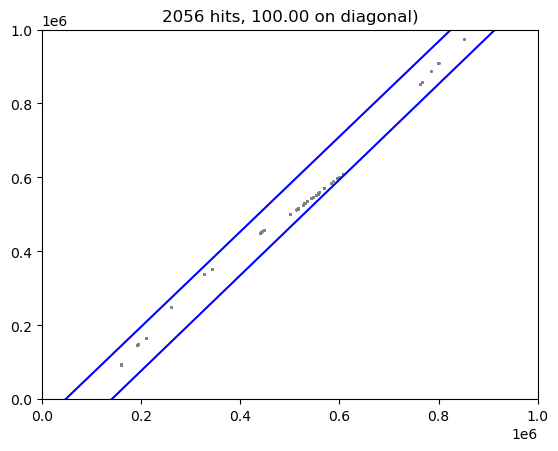

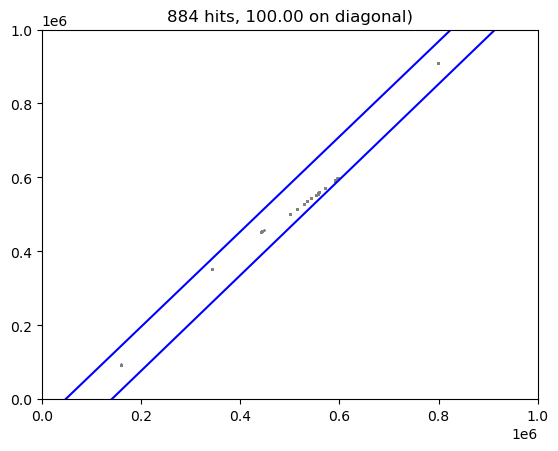

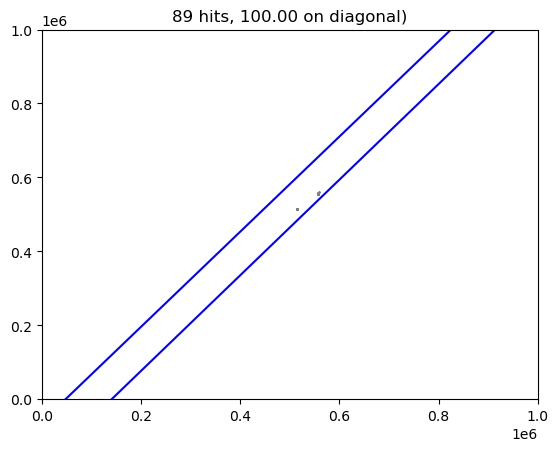

In [57]:
plot_hits(hits3)
plot_hits(hits4)
plot_hits(hits5)

2c. (2pts) Although all the plots above require the same number of matches (`30=60/2=90/3=120/4`), they each have different specificity to the diagonal. What factors do you think affect this specificity? Which is the highest, and why do you think this might be the case?

*Answer: * Despite having the same number of overall nucleotides, the longer kmers are going to have less hits. This is likely due to the fact that sequences often repeat themselves to code for the same amino acids, so when we begin skipping over nucleotides, we're looking at places where the sequences are more likely to be coding for entirely different amino acids.

## Detecting Inversions.

Chrosomal rearrangements occur when pieces of a chromosome might be missing, duplicated or moved around. In this question, we will be looking at **inversions**. Inversions occur when a stretch of DNA is spliced out from the complementary strand and inserted in reverse orientation. For example `CGT[GATT]AGA` becomes `CGT[AATC]AGA`. Pay attention to the fact that the **complementary** sequence is inserted.

3a. (4pts) We will build up to writing a function to compute the inversion of a sequence.

(i) (2pts) First, write a function that finds the complement of a sequence of DNA. In the complementary sequence, Adenine (A) is always paired with Thymine (T), and Cytosine (C) is always paired with Guanine (G).

In [87]:
def complement(sequence):
    """
  Return the reverse complement of the input sequence, according to
  the following map:
  {'A':'T','T':'A','C':'G','G':'C'}
  If any other input nucleotide chatacters are input, return 'N' in the string.

  @param: (str) sequence - input sequence consisting of 'ATCG'
  @return: (str) complementary sequence
  """

  # YOUR CODE HERE.
    
    base = {"A": "T", "T": "A", "G": "C", "C": "G"}
    complement = ""
    
    for nucleotide in sequence:
        complement += base.get(nucleotide, 'N')


    return complement

In [88]:
complement('ATCGATCGQ')

'TAGCTAGCN'

(ii) (1pt) Now, write a function that computes the reverse of a string. For example `cabbage` becomes `egabbac`. Hint! You can do this in one line (without any loops).

In [78]:
def reverse(sequence):
    
    return ''.join(reversed(sequence))

In [79]:
reverse('cabbage')

'egabbac'

(iii) (1pt) Put these together to compute the reverse complement in the function below.

In [89]:
def reverse_complement(sequence):
    """
  Return the reverse complement of the input sequence, according to
  the following map:
  {'A':'T','T':'A','C':'G','G':'C'}
  If any other input nucleotide chatacters are input, return 'N' in the string.

  @param - str(sequence). Input sequence consisting of 'ATCG'
  @return - str reverse_complement sequence
  """

  # YOUR CODE HERE
    base = {"A": "T", "T": "A", "G": "C", "C": "G"}
    complement = ""
    
    for nucleotide in sequence:
        complement += base.get(nucleotide, 'N')


    return ''.join(reversed(complement))


In [90]:
reverse_complement('ATCGATCGQ')

'NCGATCGAT'

3b. (2pts) We will use this function to help us detect inversions in our data.

(i) (1pt) First, read the `human-hoxa-region-modified.fa` fasta file as a string, and save it as the variable `seq1_inversion`.

In [91]:
seq1_inversion = str(seq2)

(ii) (1pt) Write a function below which allows you to detect inversions. This will be similar to your previous function `collect_hits()`, but you must now compare kmers from sequence 1 to their reverse complement in sequence 2.

In [93]:
def collect_inversion_hits(seq1, seq2, kmerlen=30):
    """
  Find all positions on (seq1, seq2) where there is a matching k-mer.

  For example, if we consider an exact match rule with a k- mer length f 4:
   seq1[10] = 'AATC' and seq2[50] = 'AATC'
  would register a hit at position (10,50).

  @param: (str) seq1 representing sequence 1 to be aligned
  @param: (str) seq2 representing sequence 2 to be aligned
  @param: (int) kmerlen representing the length of k-mers to be hashed (default 30)
  @param: (int) n representing the number how frequently to subselect bases from

  @ return: (list of tuples) where each entry on the list is a tuple of integers
            ([p1, p2]), at 'matching' where positions p1 represents the position
            on seq1 and p2 represents the position on seq2
  """

  # List of hit positions
    hits = []

  # Dictionary to store hashes of positions where k-mers are located
    lookup = {}

    def reverse_complement(sequence):

        base = {"A": "T", "T": "A", "G": "C", "C": "G"}
        complement = ""
    
        for nucleotide in sequence:
            complement += base.get(nucleotide, 'N')


        return ''.join(reversed(complement))
    
    print('Hashing sequence 1...')
    for pos1 in range(len(seq1) - kmerlen + 1):
        kmer = seq1[pos1:pos1 + kmerlen]
        lookup.setdefault(kmer, []).append(pos1)


    print('Hashing sequence 2...')
    for pos2 in range(len(seq2) - kmerlen + 1):
        kmer = seq2[pos2:pos2 + kmerlen]
        reverse_kmer = reverse_complement(kmer)

    # Lookup the reverse complement of the kmer locations in the lookup table
    
        if reverse_kmer in lookup:
            for pos1 in lookup[reverse_kmer]:
                hits.append((pos1, pos2))
                
    return hits

3c. (i) Use the function you wrote in part (b) and the dotplot to find the position of the inversion in the modified HoxA region. You can experiment with different values of kmer length to get the clearest results

Hashing sequence 1...
Hashing sequence 2...


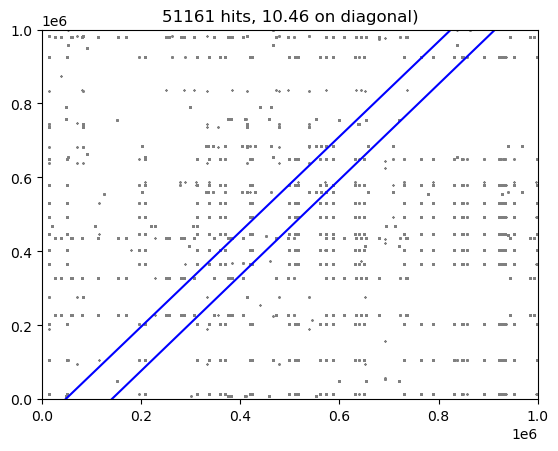

In [94]:
hits = collect_inversion_hits(seq1, seq1_inversion, kmerlen=30)
plot_hits(hits)

Hashing sequence 1...
Hashing sequence 2...


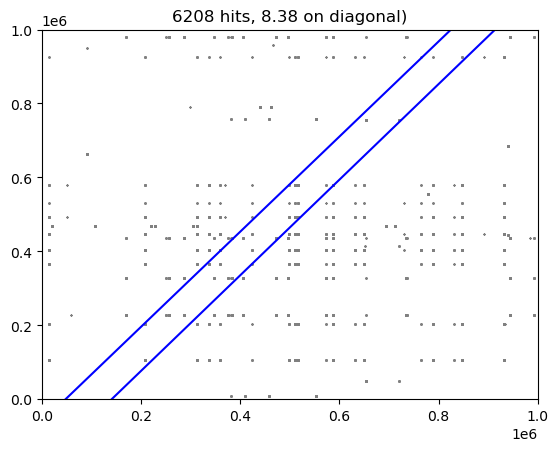

In [98]:
Hits = collect_inversion_hits(seq1, seq1_inversion, kmerlen=40)
plot_hits(Hits)

(ii)  (2pts) Can you detect the inversion? Why does this plot reveal the location of inversions?

*Answer:* Inversions are detected throughout the sequence. The graph shows that 10.46% of the inversions are within the diagnol (when using kmerlen=30), meaning they line up around the same area of the original sequence and the inversion. Increasing the kmerlen by just 10 causes a significant reductioin in hits, and most of them line up around the middle, but still not in the diagnol. It is difficult to discern a clear pattern from these graphs however.

3d. (2pts) Other potential chromosomal rearrangements include deletions and duplications. Explain how you would use this framework to detect such events. What would they look like on the dotplot?

*Answer:* For duplications, you would look for k-mers that occur more frequently than expected within a given stretch of sequence. Multiple hits in different regions or extra hits alongside the main diagonal would be indicative of duplicated sequences.
For deletions, the approach would be to identify regions where expected k-mers are missing. If a sequence is expected to have a k-mer based on its presence in a reference or a comparative sequence but does not, this could indicate a possible deletion.